# Connect to Drive & Read

In [1]:
# pip install plotly==4.5.0

In [1]:
from google.colab import drive
import pandas as pd, numpy as np
from plotly import express as px
#  pip install -U kaleido

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_pickle("/content/drive/MyDrive/CMG - Crystal Prediction Project/Ternary Materials Point Group Prediction/Data/NOMAD_2/Classification_Data_8.pkl").dropna()
print(df.shape)
df.head()

(1381099, 24)


,Atomic Number 1,Atomic Number 2,Atomic Number 3,Element_1,Element_2,Element_3,Coefficient 1,Coefficient 2,Coefficient 3,formula_reduced,bravais_lattice,crystal_system,space_group_number,point_group,lattice_parameters,Oxidation 1,Oxidation 2,Oxidation 3,IonicRadius_1,IonicRadius_2,IonicRadius_3,IonizationPot1st_1,IonizationPot1st_2,IonizationPot1st_3
0,3,5,41,Li,B,Nb,4,1,1,BLi4Nb,cF,cubic,216,-43m,"{'a': 6.71860936e-10, 'b': 6.71860936e-10, 'c'...",1,-1,-3,0.755440,1.048943,1.842691,5.3917,8.298,6.7589
1,4,5,41,Be,B,Nb,4,1,1,BBe4Nb,cF,cubic,216,-43m,"{'a': 6.119642980000002e-10, 'b': 6.1196429800...",1,-1,-3,0.643658,1.048943,1.842691,9.3226,8.298,6.7589
2,4,5,41,Be,B,Nb,2,1,1,BBe2Nb,cF,cubic,216,-43m,"{'a': 5.458027e-10, 'b': 5.458027e-10, 'c': 5....",2,-1,-3,0.452080,1.048943,1.842691,9.3226,8.298,6.7589
3,4,5,41,Be,B,Nb,2,1,1,BBe2Nb,cF,cubic,225,m-3m,"{'a': 5.420156379999999e-10, 'b': 5.4201563799...",2,-1,-3,0.452080,1.048943,1.842691,9.3226,8.298,6.7589
4,4,5,41,Be,B,Nb,2,1,1,BBe2Nb,mS,monoclinic,12,2/m,"{'a': 4.660283620000524e-10, 'b': 8.41781306e-...",2,-1,-3,0.452080,1.048943,1.842691,9.3226,8.298,6.7589


**Config**

In [5]:
FEATURE_NAMES = [
#     "Atomic Number 1","Atomic Number 2","Atomic Number 3",
    "Coefficient 1", "Coefficient 2", "Coefficient 3", 
    "IonizationPot1st_1", "IonizationPot1st_2", "IonizationPot1st_3", 
    "Oxidation 1", "Oxidation 2", "Oxidation 3", # Used to be electronegativity 
    "IonicRadius_1", "IonicRadius_2", "IonicRadius_3"
]

GROUPERS = [
    "Atomic Number 1","Atomic Number 2","Atomic Number 3",
    "Coefficient 1", "Coefficient 2", "Coefficient 3"
]

# Y_NAME = 'crystal_system'
Y_NAME = 'bravais_lattice'
# Y_NAME = 'point_group'
# Y_NAME = 'space_group_number'

# Preprocess

In [6]:
df['crystal_system'].replace(to_replace="trigonal", value="hexagonal", inplace=True)
df['space_group_number'] = df['space_group_number'].astype(int)

In [7]:
df_dedup = df[FEATURE_NAMES+[Y_NAME]].drop_duplicates().copy()
df_dedup[Y_NAME] = df_dedup[Y_NAME].astype(str)
df_dedup[Y_NAME].unique().shape

(14,)

In [8]:
# value_counts = df_dedup[Y_NAME].value_counts()
# value_counts.index = value_counts.index.astype(str)
# fig = px.bar(x=value_counts.index, y=value_counts.values)
# fig.update_layout( 
#     width=3000,
#     yaxis=dict(title='Count'),
#     xaxis=dict(
#         title='Space Group',
#         tickmode='linear',
#         tickangle=60,
#         type='category'
#     )
# )

In [9]:
# df['Counter'] = 1

In [10]:
# sun_chart_df = df.groupby(['crystal_system', 'bravais_lattice', 'point_group', 'space_group_number'])['Counter'].sum().reset_index()

In [11]:
# import plotly.express as px
# fig = px.sunburst(sun_chart_df, path=['crystal_system', 'bravais_lattice', 'point_group'], values='Counter')
# fig.update_layout(
#     autosize=False,
#     width=1200,
#     height=1200,)

# fig.write_image("images/fig1.svg")
# fig.show()

# Base Experiment

1. Resample
2. Groupby (Multi-Labeled data)
3. Multi-Label Encoding
4. Train-Test Split
5. Train

In [6]:
accepted_classes = (df_dedup[Y_NAME].value_counts() > 300).replace(False, np.nan).dropna().index.tolist()
df_filtered = df_dedup[df_dedup[Y_NAME].isin(accepted_classes)].copy()
df_filtered[Y_NAME] = df_filtered[Y_NAME].astype(int)

print("Previous Data Size:", df_dedup.shape[0])
print("New Data Size:", df_filtered.shape[0])
print("Number of Classes Left:", len(accepted_classes))

Previous Data Size: 1381099
New Data Size: 1372271
Number of Classes Left: 50


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

df_grouped2 = df_filtered.groupby(FEATURE_NAMES)[Y_NAME].apply(list).reset_index()

In [8]:
ml_binner = MultiLabelBinarizer()
ml_binner.fit(df_grouped2[Y_NAME])
y = ml_binner.transform(df_grouped2[Y_NAME])
X = df_grouped2[FEATURE_NAMES].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
clf = RandomForestClassifier(n_estimators=50, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=0)

In [11]:
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
target_names = ml_binner.classes_
print(classification_report(y_test, y_pred, target_names=[str(i) for i in target_names]))

# Iterations

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, balanced_accuracy_score, matthews_corrcoef, confusion_matrix

def prepare_train_test(df):
    ml_binner = MultiLabelBinarizer()
    ml_binner.fit(df[Y_NAME])
    y = ml_binner.transform(df[Y_NAME])
    X = df[FEATURE_NAMES].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test, ml_binner

def get_confusion(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return TN, TP, FN, FP

def calc_wba_wmcc_conf(y_true, y_pred):
    """Calculated the weighted balanced accuracy and mathews correlation coefficient
    """
    n_lst = []
    ba_lst = []
    mcc_lst = []
    tn_lst = []
    tp_lst = []
    fn_lst = []
    fp_lst = []
    for idx in range(y_true.shape[1]):
        class_true = y_true[:, idx]
        class_preds = y_pred[:, idx]
        N = sum(class_true)
        BA = balanced_accuracy_score(class_true, class_preds, adjusted=False)
        MCC = matthews_corrcoef(class_true, class_preds)
        TN, TP, FN, FP = get_confusion(class_true, class_preds)

        n_lst.append(N)
        mcc_lst.append(MCC)
        ba_lst.append(BA)

        tn_lst.append(TN)
        tp_lst.append(TP)
        fn_lst.append(FN)
        fp_lst.append(FP)

    weighted_balanced_acc = sum([n*ba for n,ba in zip(n_lst,ba_lst)]) / sum(sum(y_true))
    weighted_mcc = sum([n*mcc for n,mcc in zip(n_lst, mcc_lst)]) / sum(sum(y_true))
    sum_tn = sum(tn_lst)
    sum_tp = sum(tp_lst)
    sum_fn = sum(fn_lst)
    sum_fp = sum(fp_lst)

    return weighted_balanced_acc, weighted_mcc, sum_tn, sum_tp, sum_fn, sum_fp

def evaluate(y_true, y_pred):
    micro_f1 = f1_score(y_true, y_pred, average='micro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    WBA, WMCC, TN, TP, FN, FP = calc_wba_wmcc_conf(y_true, y_pred)
    metrics = {
        "WMCC": WMCC ,
        "micro_f1": micro_f1,
        "macro_f1": macro_f1,
        "WBA": WBA,
        "TN":TN,
        "TP":TP, 
        "FN":FN,
        "FP":FP
    }
    return metrics

def filter_y(df, min_class_size):
    accepted_classes = (df[Y_NAME].value_counts() > min_class_size).replace(False, np.nan).dropna().index.tolist()
    df_filtered = df[df[Y_NAME].isin(accepted_classes)].copy()
    return df_filtered

In [13]:
df_main = df_dedup.copy()


In [14]:
experiments = []

2**16

65536

In [32]:
df_main[Y_NAME].value_counts().values[::-1]

df_main[Y_NAME].unique().shape

t

[0,
 326,
 2375,
 18655,
 28230,
 68764,
 70215,
 70261,
 71027,
 71086,
 71296,
 72217,
 97143,
 102839,
 193410]

In [33]:
import gc
import pickle
threshold = [0] + list(df_main[Y_NAME].value_counts().values[::-1])

# for power in range(8, 17):
for threshold in thresholds:
    # threshold = 2**power
    
    # Filter
    df_filtered = filter_y(df_main, threshold)
    print("Number of Classes", df_filtered[Y_NAME].unique().shape)

    # Group
    df_agg = df_filtered.groupby(FEATURE_NAMES)[Y_NAME].apply(list).reset_index()

    # Prepare
    X_train, X_test, y_train, y_test, ml_binner = prepare_train_test(df_agg)

    # Learning
    clf = RandomForestClassifier(n_estimators=50, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Model is fitted.")

    # Evaluate
    eval_dict = evaluate(y_test, y_pred)

    n_classes = df_filtered[Y_NAME].unique().shape[0]
    data_size = df_agg.shape[0]

    exp = {
        "n_classes": n_classes,
        "thresh": threshold,
        "data_size": data_size,
        "evaluation": eval_dict
    }
    del df_agg, X_train, X_test, y_train, y_test, ml_binner, clf, eval_dict
    gc.collect()

    experiments.append(exp)

    with open('/content/drive/MyDrive/TemporaryColabData/tmp_exps_bl.pkl', 'wb') as f:
        pickle.dump(experiments, f)

    for key,val in exp.items():
        print(key, ":", val)
        print("-"*20)

Number of Classes (14,)
Model is fitted.
n_classes : 14
--------------------
thresh : 0
--------------------
data_size : 325107
--------------------
evaluation : {'WMCC': 0.9578755933647827, 'micro_f1': 0.9667398431018984, 'macro_f1': 0.896334202512856, 'WBA': 0.9785667749758296, 'TN': 716627, 'TP': 181212, 'FN': 6335, 'FP': 6134}
--------------------
Number of Classes (13,)
Model is fitted.
n_classes : 13
--------------------
thresh : 326
--------------------
data_size : 324838
--------------------
evaluation : {'WMCC': 0.957500259344441, 'micro_f1': 0.9665452665961534, 'macro_f1': 0.9083221109155247, 'WBA': 0.9783884170668528, 'TN': 650634, 'TP': 181393, 'FN': 6354, 'FP': 6203}
--------------------
Number of Classes (12,)
Model is fitted.
n_classes : 12
--------------------
thresh : 2375
--------------------
data_size : 323711
--------------------
evaluation : {'WMCC': 0.9592115103360926, 'micro_f1': 0.9678429515720715, 'macro_f1': 0.9530829458332638, 'WBA': 0.9792613002766494, 'TN':

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Model is fitted.


IndexError: ignored

In [35]:
# experiments

In [25]:

# import pickle
# with open('/content/drive/MyDrive/experiments_res_pgxx.pkl', 'wb') as f:
#     pickle.dump(experiments, f)


In [36]:
with open("/content/drive/MyDrive/TemporaryColabData/tmp_exps.pkl", 'rb') as f:
    x = pickle.load(f)
#     # print(x)

In [37]:
df_eval = pd.DataFrame(experiments).join(pd.DataFrame([exp['evaluation'] for exp in experiments])).drop("evaluation", axis=1)#.to_csv("eval.csv")
df_eval['WMCC'] = df_eval['WMCC'].apply(lambda x: (x+1)/2)
df_eval.to_csv("eval.csv")

In [38]:
wba_lst = [elem['evaluation']['WBA'] for elem in experiments]
macro_f_lst = [elem['evaluation']['macro_f1'] for elem in experiments]
micro_f_lst = [elem['evaluation']['micro_f1'] for elem in experiments]
wmcc_lst = [(elem['evaluation']['WMCC'] + 1) / 2 for elem in experiments]
class_size_lst = [elem['n_classes'] for elem in experiments]
thresh_lst = [elem['thresh'] for elem in experiments]
data_size_lst = [elem['data_size'] for elem in experiments]
FN_lst = [elem['evaluation']['FN'] for elem in experiments]
FP_lst = [elem['evaluation']['FP'] for elem in experiments]

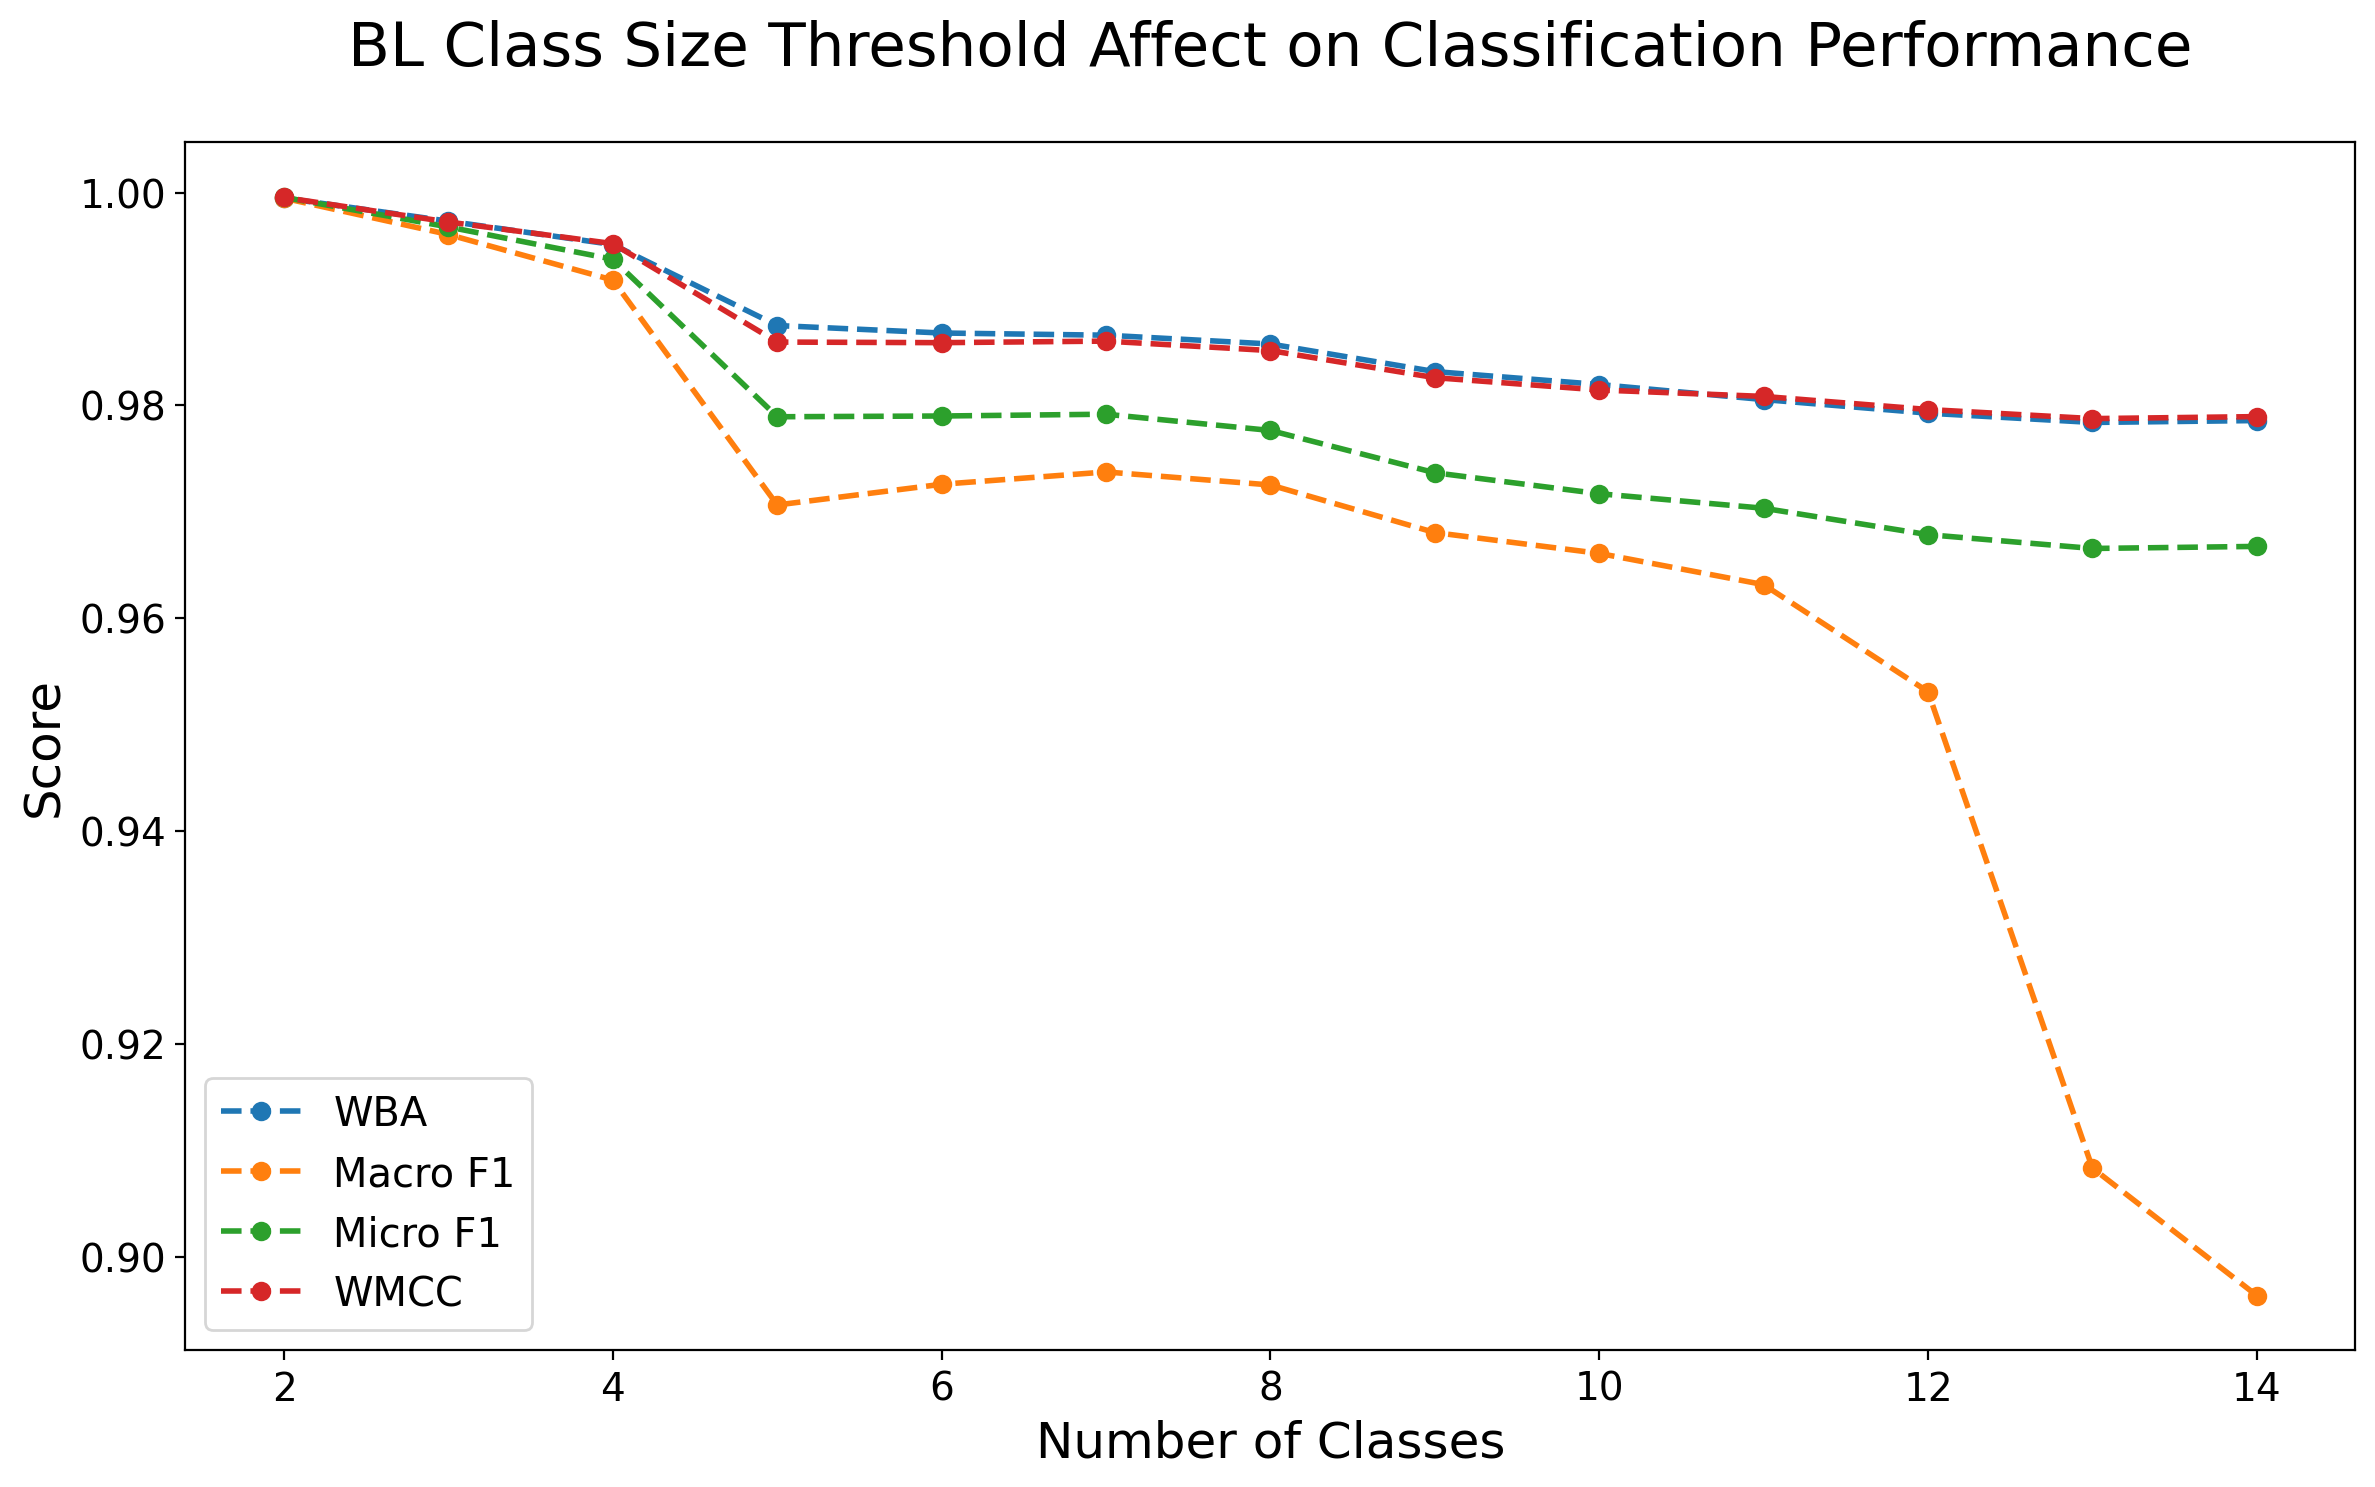

In [40]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(14, 8), dpi=200) # create figure & 1 axis


ax.plot(class_size_lst[:20], wba_lst[:20], label = 'WBA',  marker='o', linestyle='--', linewidth=2)
ax.plot(class_size_lst[:20], macro_f_lst[:20], label = 'Macro F1',  marker='o', linestyle='--', linewidth=2)
ax.plot(class_size_lst[:20], micro_f_lst[:20], label = 'Micro F1',  marker='o', linestyle='--', linewidth=2)
ax.plot(class_size_lst[:20], wmcc_lst[:20], label = 'WMCC',  marker='o', linestyle='--', linewidth=2)

      
plt.xlabel('Number of Classes', fontsize=18)
plt.ylabel('Score', fontsize=18)
plt.legend(loc='lower right')
plt.title('BL Class Size Threshold Affect on Classification Performance', fontsize=22, y=1.05)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=20) # using a size in points
plt.legend(fontsize="x-large")
plt.show()

fig.savefig('class_filter_affect_bl_1.png')   # save the figure to file
plt.close(fig)    # close the figure window

In [40]:
# plt.savefig("thresh_affect_class_change.png")
# plt.close(fig)    # close the figure window

In [46]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# figure(figsize=(14, 8), dpi=80)
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(14, 8), dpi=200) # create figure & 1 axis

ax.plot(thresh_lst[:20], wba_lst[:20], label = 'WBA',  marker='o', linestyle='--', linewidth=2)
ax.plot(thresh_lst[:20], macro_f_lst[:20], label = 'Macro F1',  marker='o', linestyle='--', linewidth=2)
ax.plot(thresh_lst[:20], micro_f_lst[:20], label = 'Micro F1',  marker='o', linestyle='--', linewidth=2)
ax.plot(thresh_lst[:20], wmcc_lst[:20], label = 'WMCC',  marker='o', linestyle='--', linewidth=2)

      
plt.xlabel('Class Size Threshold', fontsize=18)
plt.ylabel('Score', fontsize=18)
plt.legend(loc='lower right')
plt.title('BL Class Size Threshold Affect on Classification Performance', fontsize=22, y=1.05)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_xscale('log', basex=2)

plt.legend(fontsize=20) # using a size in points
plt.legend(fontsize="x-large")
# plt.show()

plt.savefig("class_filter_affect_bl_2.png")
plt.close(fig)    # close the figure window

In [ ]:


# import matplotlib.pyplot as plt
# from matplotlib.pyplot import figure

# figure(figsize=(14, 8), dpi=80)


# plt.plot(data_size_lst[:20], wba_lst[:20], label = 'WBA',  marker='o', linestyle='--', linewidth=2)
# plt.plot(data_size_lst[:20], macro_f_lst[:20], label = 'Macro F1',  marker='o', linestyle='--', linewidth=2)
# plt.plot(data_size_lst[:20], micro_f_lst[:20], label = 'Micro F1',  marker='o', linestyle='--', linewidth=2)
# plt.plot(data_size_lst[:20], wmcc_lst[:20], label = 'WMCC',  marker='o', linestyle='--', linewidth=2)

      
# plt.xlabel('Class Size Threshold', fontsize=18)
# plt.ylabel('Score', fontsize=18)
# plt.legend(loc='lower right')
# plt.title('Class Size Threshold Affect on Classification Performance', fontsize=22, y=1.05)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)



# plt.legend(fontsize=20) # using a size in points
# plt.legend(fontsize="x-large")
# plt.gca().invert_xaxis()
# plt.show() 

In [ ]:


# import matplotlib.pyplot as plt
# from matplotlib.pyplot import figure

# fig, ax = plt.subplots(1,1, figsize=(14,8))



# ax.plot(data_size_lst[:20], wba_lst[:20], label = 'WBA',  marker='o', linestyle='--', linewidth=2)
# ax.plot(data_size_lst[:20], macro_f_lst[:20], label = 'Macro F1',  marker='o', linestyle='--', linewidth=2)
# ax.plot(data_size_lst[:20], micro_f_lst[:20], label = 'Micro F1',  marker='o', linestyle='--', linewidth=2)
# ax.plot(data_size_lst[:20], wmcc_lst[:20], label = 'WMCC',  marker='o', linestyle='--', linewidth=2)

      
# plt.xlabel('Class Size Threshold', fontsize=18)
# plt.ylabel('Score', fontsize=18)
# ax.legend(loc='lower right')
# plt.title('Class Size Threshold Affect on Classification Performance', fontsize=22, y=1.05)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# ax.set_xticklabels([str(i) for i in data_size_lst[:20]])


# plt.legend(fontsize=20) # using a size in points
# plt.legend(fontsize="x-large")
# plt.gca().invert_xaxis()
# plt.show()

In [31]:
wba_lst = [elem['evaluation']['WBA'] for elem in experiments]
macro_f_lst = [elem['evaluation']['macro_f1'] for elem in experiments]
micro_f_lst = [elem['evaluation']['micro_f1'] for elem in experiments]
wmcc_lst = [(elem['evaluation']['WMCC'] + 1) / 2 for elem in experiments]
class_size_lst = [elem['n_classes'] for elem in experiments]
thresh_lst = [elem['thresh'] for elem in experiments]
data_size_lst = [elem['data_size'] for elem in experiments]
FN_lst = [elem['evaluation']['FN'] for elem in experiments]
FP_lst = [elem['evaluation']['FP'] for elem in experiments]

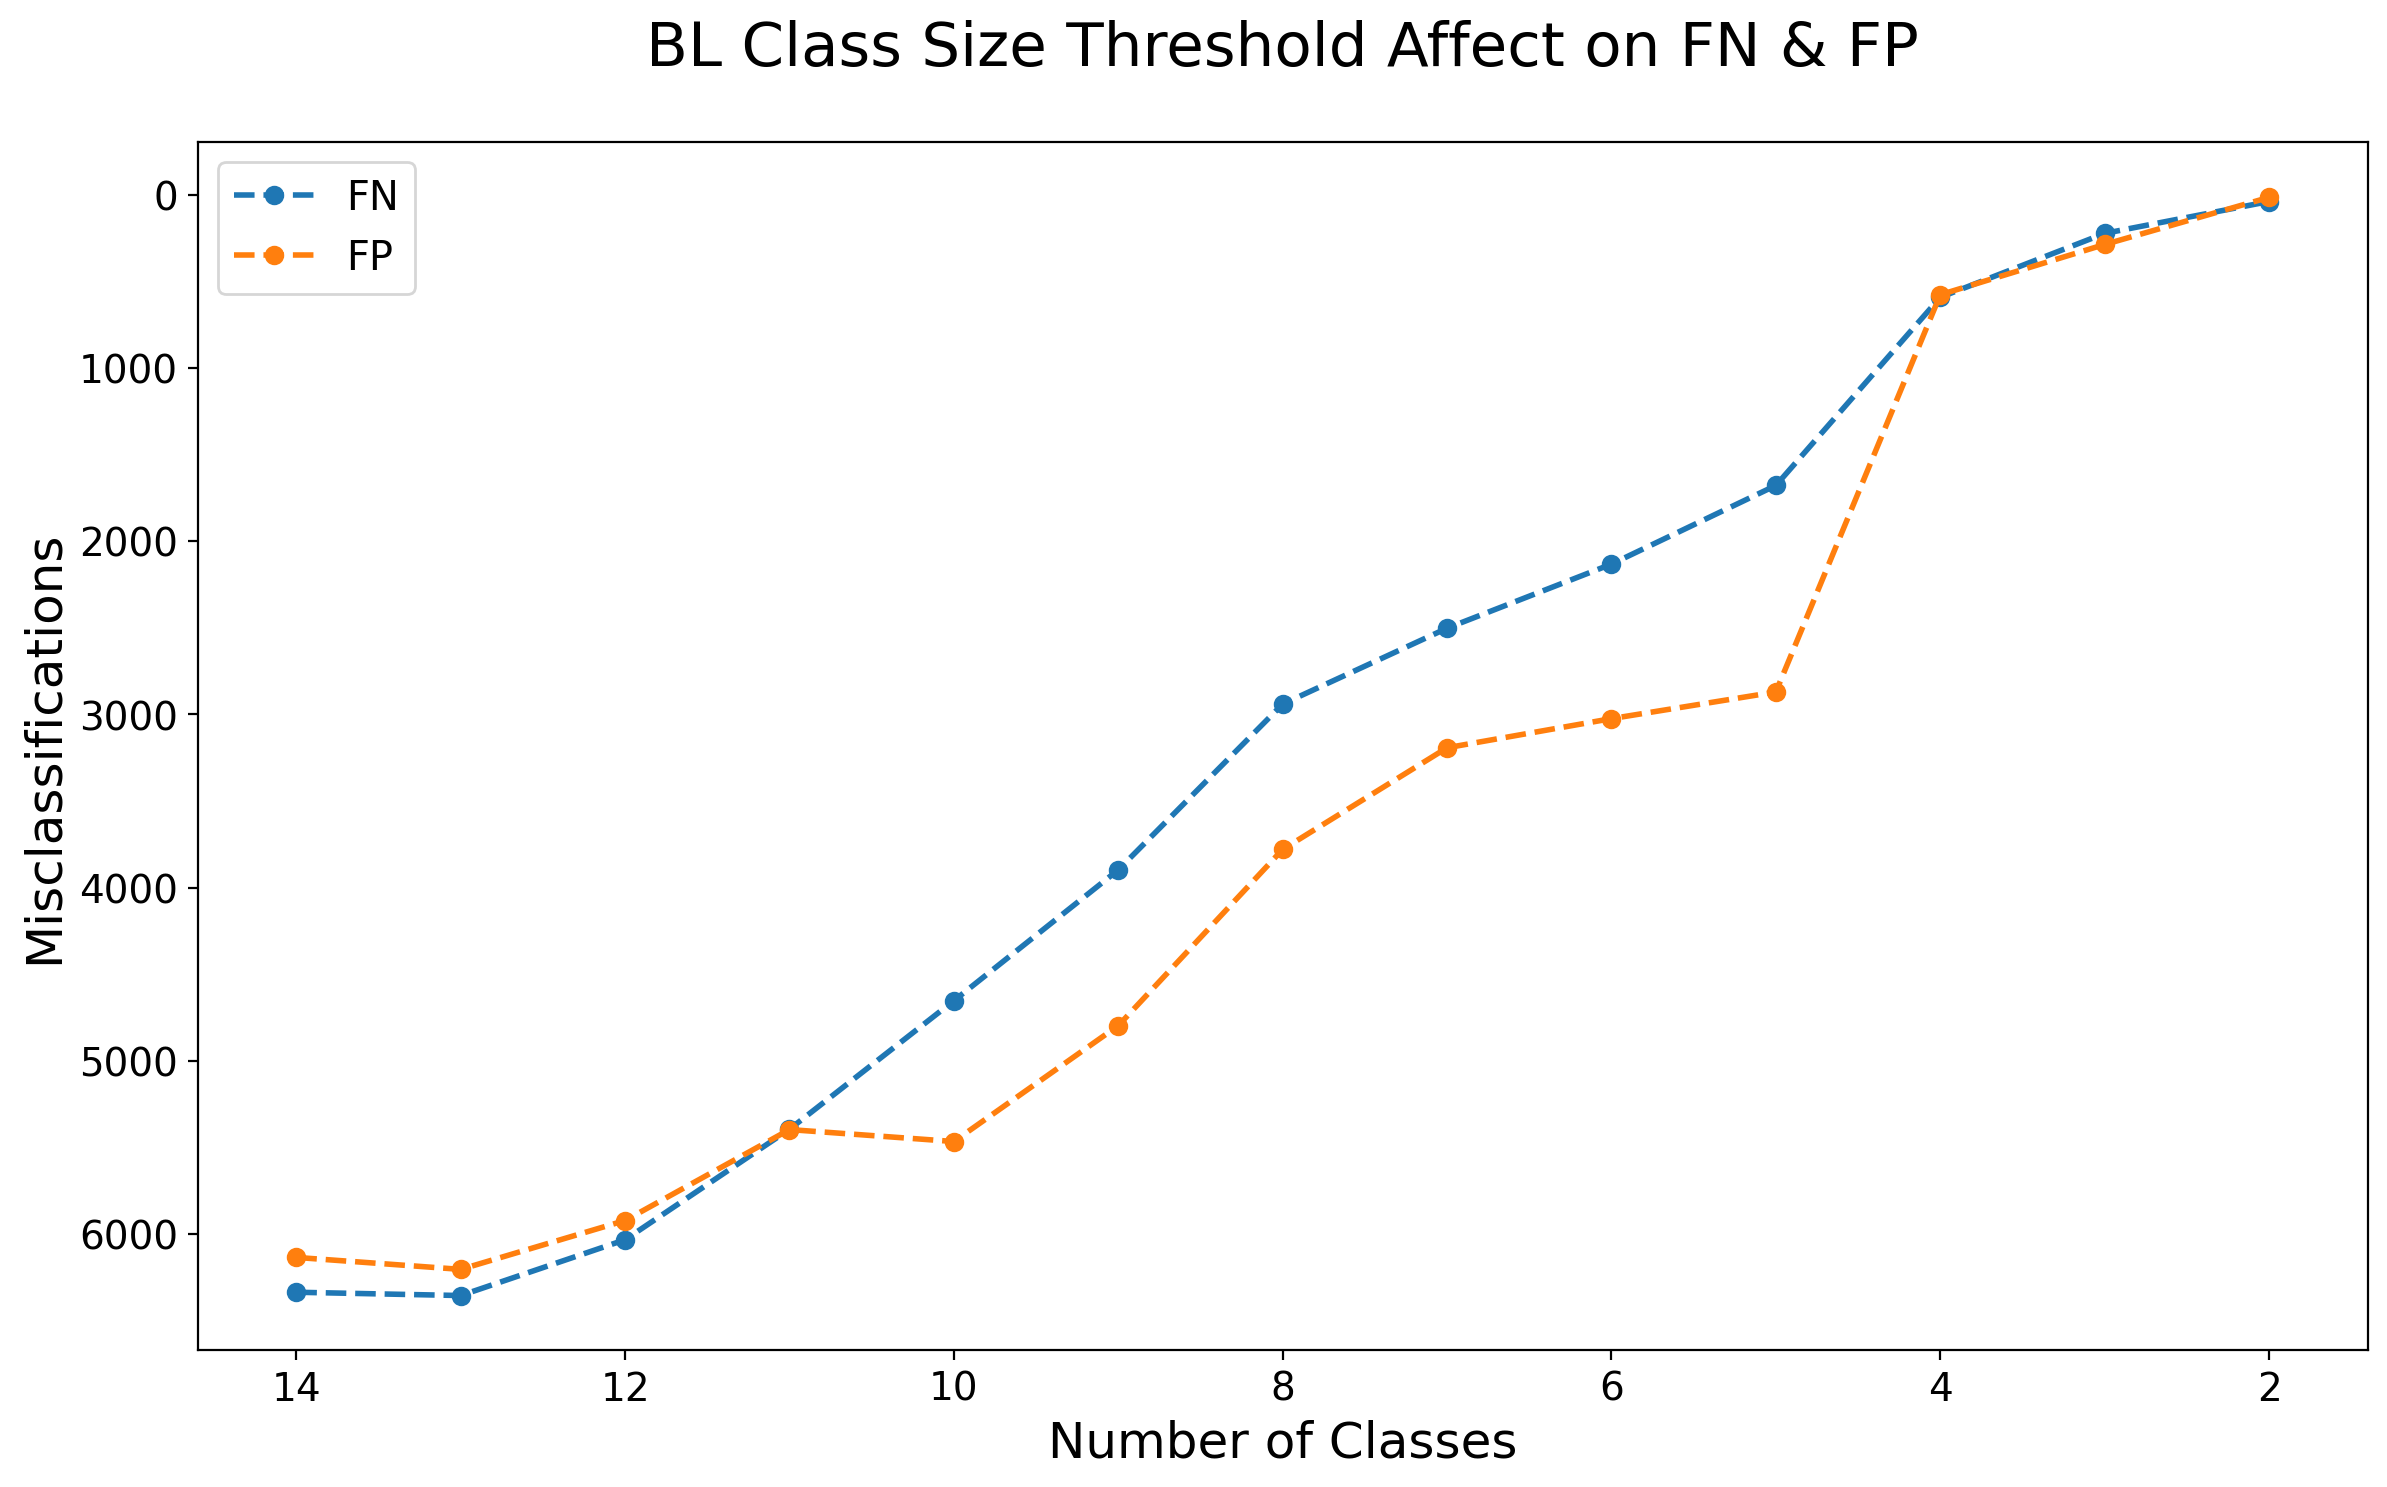

In [43]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(14, 8), dpi=200) # create figure & 1 axis
ax.plot(class_size_lst[:20], FN_lst[:20], label = 'FN',  marker='o', linestyle='--', linewidth=2)
ax.plot(class_size_lst[:20], FP_lst[:20], label = 'FP',  marker='o', linestyle='--', linewidth=2)


# Format
plt.xlabel('Number of Classes', fontsize=18)
plt.ylabel('Misclassifications', fontsize=18)
plt.legend(loc='lower right')
plt.title('BL Class Size Threshold Affect on FN & FP', fontsize=22, y=1.05)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize="x-large")
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

fig.savefig('class_filter_affect_bl_errors.png')   # save the figure to file
plt.close(fig)